# DMR Practical Assignment: Recover a broken robot

## Recursive Bayesian estimation

Localisation is a key problem in robotics, and a number of approaches have been proposed to address this. Recursive Bayesian estimation using the discrete Bayes filter is one such approach. 

We start by assuming that a robot has state $\mathbf{x}_k$ at time step $k$, and can be commanded to take actions $\mathbf{a}_k$. Let us also assume that the robot is able to sense the environment it finds itself in and obtains measurement $\mathbf{z}_k$.

Recursive Bayesian estimation is a sequential technique for maintaining a belief over a state, conditioned on a series of measurements, $p(\mathbf{x}_k|\mathbf{z}_{1:k})$. We briefly derive the equations for recursive Bayesian estimation below. First, we will use Bayes rule to rewrite the desired posterior belief,

$$p(\mathbf{x}_k|\mathbf{z}_{1:k}) = \frac{p(\mathbf{z}_{1:k}|\mathbf{x}_k)p(\mathbf{x}_k)}{p(\mathbf{z}_{1:k})}$$

We factorise the trajectory likelihood $p(\mathbf{z}_{1:k}|\mathbf{x}_k)$ in the numerator, to produce

$$p(\mathbf{x}_k|\mathbf{z}_{1:k}) = \frac{p(\mathbf{z}_{k}|\mathbf{x}_k,\mathbf{z}_{1:k-1})p(\mathbf{z}_{1:k-1}|\mathbf{x}_k)p(\mathbf{x}_k)}{p(\mathbf{z}_{k}|\mathbf{z}_{1:k-1})p(\mathbf{z}_{1:k-1})}$$

The second half of this equation can be simplified using Bayes rule, providing:
$$p(\mathbf{x}_k|\mathbf{z}_{1:k}) = \frac{p(\mathbf{z}_{k}|\mathbf{x}_k,\mathbf{z}_{1:k-1})p(\mathbf{x}_k|\mathbf{z}_{1:k-1})}{p(\mathbf{z}_{k}|\mathbf{z}_{1:k-1})}$$

Let us assume that our robot is Markovian, that is, measurements $\mathbf{z}_k$ are only dependent on state $\mathbf{x}_k$, and state $\mathbf{x}_k$ is only dependent on previous state $\mathbf{x}_{k-1}$. Then we can simplify the equation above even further,

$$p(\mathbf{x}_k|\mathbf{z}_{1:k}) = \frac{p(\mathbf{z}_{k}|\mathbf{x}_k)p(\mathbf{x}_k|\mathbf{z}_{1:k-1})}{p(\mathbf{z}_{k}|\mathbf{z}_{1:k-1})}$$

This equation is pretty interesting, the first part $p(\mathbf{z}_{k}|\mathbf{x}_k)$ is a likelihood - how likely are you to make the measurement $\mathbf{z}_k$ given you are in state $\mathbf{x}_k$. The denominator bit is just a normalising term, so we'll ignore this.

The term $p(\mathbf{x}_k|\mathbf{z}_{1:k-1})$ is a prediction of the state given the history of measurements. Lets assume we have a transition model of robot motion $p(\mathbf{x}_k|\mathbf{x}_{k-1},\mathbf{a}_k)$. Then we can make a prediction about where our robot will be for a given state if we apply an action.

$$p(\mathbf{x}_k|\mathbf{z}_{1:k-1}) = \int{p(\mathbf{x}_k|\mathbf{x}_{k-1},\mathbf{a}_k)p(\mathbf{x}_{k-1}|\mathbf{z}_{1:k-1})\text{d}\mathbf{x}_{k-1}}$$

This equation is extremely powerful - it computes the probability of occupying a state for a given action, by taking into account all the possible states we could have come from, along with the prior belief that we had in these states, $p(\mathbf{x}_{k-1}|\mathbf{z}_{1:k-1})$. This is called the total probability rule.

What's key here is that we have a recursive means of maintaining a belief over the world as we take actions, given a model of how we gain information from the world, and a model of how we interact with the world. This allows us to continue to update our beliefs as we act in the world and receive new information.

To summarise, first we make a prediction about the likely state of the world if we were to take an action:

$$p(\mathbf{x}_k|\mathbf{z}_{1:k-1}) = \int{p(\mathbf{x}_k|\mathbf{x}_{k-1},\mathbf{a}_k)p(\mathbf{x}_{k-1}|\mathbf{z}_{1:k-1})\text{d}\mathbf{x}_{k-1}}$$

Then we take the action, sense the world and update our belief in the states.

$$p(\mathbf{x}_k|\mathbf{z}_{1:k}) \propto p(\mathbf{z}_{k}|\mathbf{x}_k)p(\mathbf{x}_k|\mathbf{z}_{1:k-1})$$

We repeat this as new information is gathered and actions are taken, continually refining our beliefs.


## The discrete Bayes filter (DBF)

The discrete Bayes filter is a discrete form of recursive Bayesian estimation. Here, we discretise the world into a number of possible states $\mathbf{x}^j$, and maintain beliefs using discrete random variables for each possible state.

Since our belief is over a finite set of $j$ states, the integral in the equation above changes to a sum for the discrete bayes filter prediction step,

$$p(\mathbf{x}^j_k|\mathbf{z}_{1:k-1}) = \sum_{x_i}{p(\mathbf{x}^j_k|\mathbf{x}^i_{k-1},\mathbf{a}_k)p(\mathbf{x}^i_{k-1}|\mathbf{z}_{1:k-1})}$$

Then we sense the world and update our belief in the states.

$$p(\mathbf{x}^j_k|\mathbf{z}_{1:k}) \propto p(\mathbf{z}_{k}|\mathbf{x}^j_k)p(\mathbf{x}^j_k|\mathbf{z}_{1:k-1})$$

References:
http://www.probabilistic-robotics.org/ 



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from helper_funcs import Robot, make_world

# Assignment

Let us assume you have a faulty robot equipped with a metal detector. The robot can sense if there is metal near it (p_sense_succeed = 0.8), but occasionally it's sensors fail (p_sense_fail = 0.2) and it returns the wrong measurement.

The robot can take random actions to move a step to the left, right, up, down, or diagonally, but this is also unreliable. Sometimes it behaves (p_move_succeed = 0.9), but occasionally it just stays where it was (p_move_fail = 0.1)

Unfortunately, your robot is lost somewhere in a grid. Luckily, it managed to make a map of locations of the metal in the world before getting lost. Your goal is to use this map, together with sensor measurements, to figure out where your robot is so that you can recover it.

Complete the program below to implement the prediction and likelihood calculations for a discrete Bayes filter, in order to find out where your robot is. One you have completed this, compile a report including images of the distributions at convergence, and briefly discussing your solutions.

Try to answer at least three of the following questions in the report:

* How quickly does the DBF converge to a good belief? (re-run multiple times)
* How do the sensing and move failure probabilities affect inference?
* How does the environment affect the quality of the belief in position?
* How does the predictive distribution change the posterior from one time step before?
* When is a MAP estimator a good one? Are there better estimators for this problem?
* When would the best time to attempt to recover your robot be?
* Assume you can choose actions to take instead of executing random ones. What actions could you take to reduce the uncertainty in the robot position?

This task is inspired by the search for the wreckage of Air France Flight AF 4471
https://arxiv.org/pdf/1405.4720.pdf


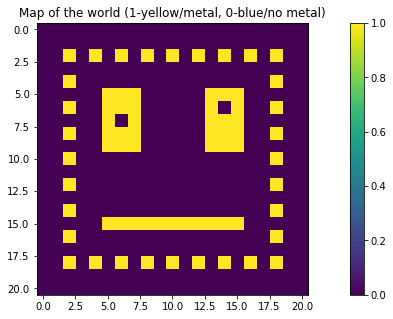

In [2]:
# Initialise world and agent in it
p_move = 0.9
p_sense = 0.8

world = make_world()
N = world.shape[0]

agent = Robot(p_move,p_sense,world)

# Create list of possible states in world (x,y coordinates)
possible_states = np.array(np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,N-1,N))).reshape(2,-1).T

# Initialise belief in position - uniform distribution over world
state_belief = np.ones((N,N))/(N*N)

plt.figure(figsize=(15,5))
plt.imshow(world)
plt.title('Map of the world (1-yellow/metal, 0-blue/no metal)')
plt.colorbar()
plt.show()

Since our belief is over a finite set of $j$ states, the integral in the equation above changes to a sum for the discrete bayes filter prediction step,

$$p(\mathbf{x}^j_k|\mathbf{z}_{1:k-1}) = \sum_{x_i}{p(\mathbf{x}^j_k|\mathbf{x}^i_{k-1},\mathbf{a}_k)p(\mathbf{x}^i_{k-1}|\mathbf{z}_{1:k-1})}$$

Then we sense the world and update our belief in the states.

$$p(\mathbf{x}^j_k|\mathbf{z}_{1:k}) \propto p(\mathbf{z}_{k}|\mathbf{x}^j_k)p(\mathbf{x}^j_k|\mathbf{z}_{1:k-1})$$

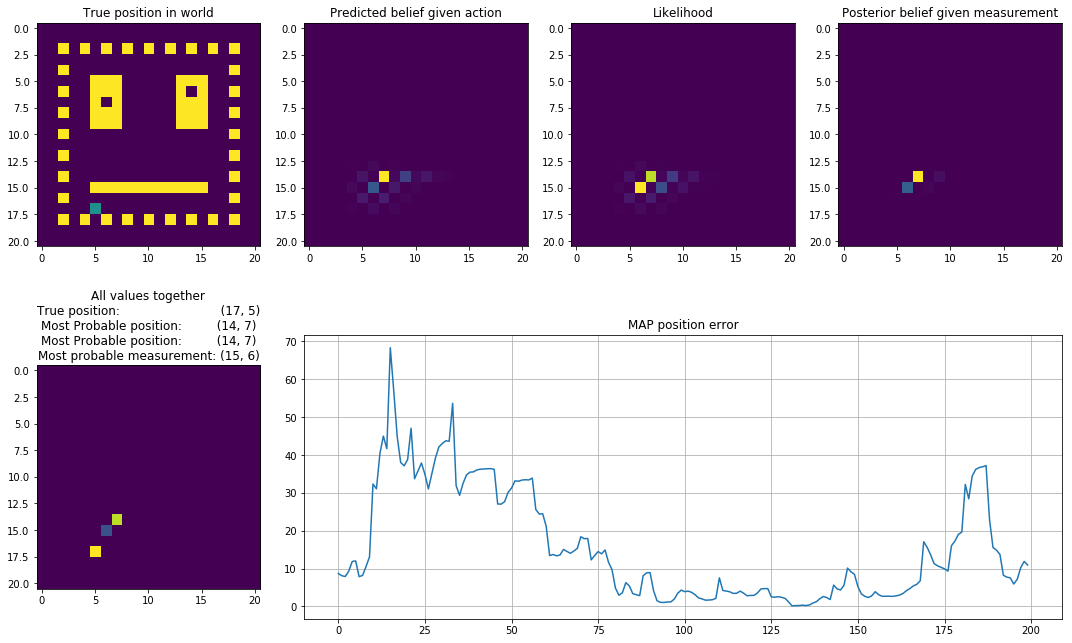

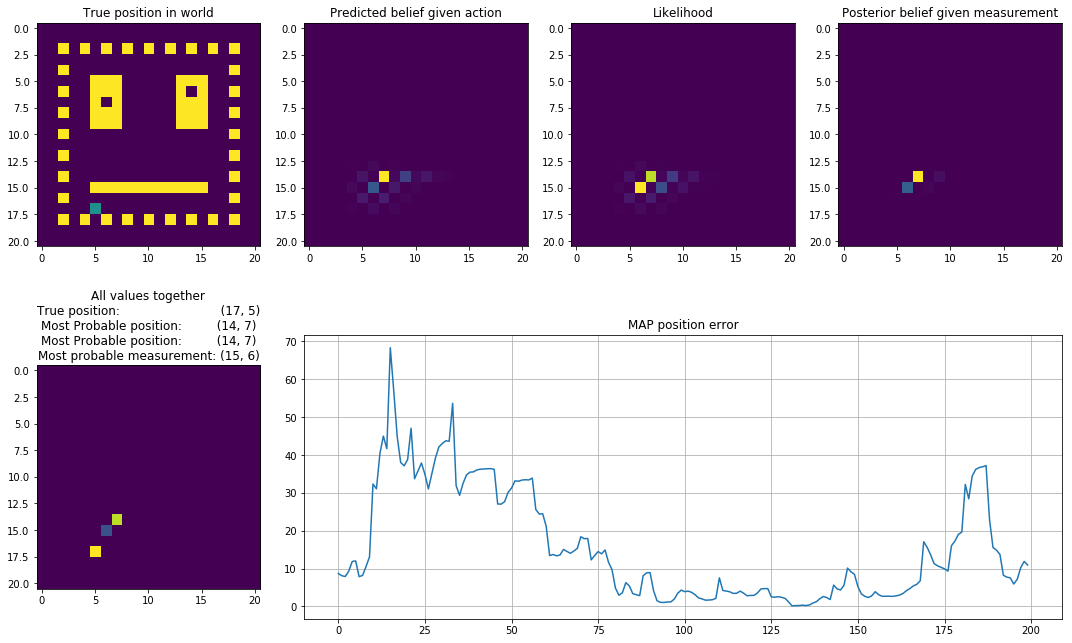

In [3]:
# Run the discrete Bayes filter
plt.figure(figsize=(15,9))

for j in range(200):
    
    # Sample a random action
    a = np.sign((np.random.rand(2,)-0.5))
    
    # Apply action and sense
    measurement = agent.move_and_sense(a)
    
    # Make prediction about state belief given action
    predicted_state_belief = np.zeros((N,N))
    for state in possible_states.astype(int):
        
        new_state = agent.move_perfect(state,a)
        
############################ Complete this section ##########################################
        
        if 'likelihood' not in locals():
            likelihood = np.zeros((N,N))+1/N**2
            
        predicted_state_belief[new_state[0],new_state[1]] = \
            0.1*likelihood[new_state[0],new_state[1]] + 0.9*likelihood[state[0],state[1]]
                
#############################################################################################
   
    # Evaluate sensor belief for each possible state
    likelihood = np.zeros((N,N))
    for state in possible_states.astype(int):
        
############################ Complete this section ##########################################
        
        #Hint the expected measurement in a given state is world[state[0],state[1]]

        likelihood[state[0],state[1]] = \
            (0.8 if measurement == world[state[0],state[1]] else 0.2) * \
            predicted_state_belief[state[0],state[1]]
           
    likelihood = likelihood / likelihood.sum()     
    
#############################################################################################

    
    # Compute posterior belief over possible states
    state_belief = likelihood*predicted_state_belief
    
    # Tip: never become overconfident, so add some probability mass to all possible states before normalising
    state_belief = (state_belief+1e-15)
    state_belief = state_belief/np.sum(state_belief) 
    
    # Compute Maximum a-posteriori position estimate
    map_estimate = np.sum(possible_states*state_belief.T.reshape(-1,1),axis=0)

    # Compute most probable positions
    true_position_val = tuple([int(el) for el in agent.state])
    most_probable_position_val = np.unravel_index(state_belief.argmax(), state_belief.shape)
    most_probable_position_without_measurement_val = np.unravel_index(
        predicted_state_belief.argmax(),
        predicted_state_belief.shape)
    most_probable_measurement_val = np.unravel_index(likelihood.argmax(), likelihood.shape)
    
    # Compute messages
    true_position = 'True position:\t\t\t\t%s' \
            % str(true_position_val)
    most_probable_position = 'Most Probable position: \t%s' \
            % str(most_probable_position_val)
    most_probable_position_without_measurement = 'Most Probable position: \t%s' \
            % str(most_probable_position_without_measurement_val)
    most_probable_measurement = 'Most probable measurement: %s' \
            % str(most_probable_measurement_val)
    
    # Compute matrix for all values
    all_values = np.zeros((N,N))
    all_values[most_probable_measurement_val[0],most_probable_measurement_val[1]] = 0.25
    all_values[most_probable_position_without_measurement_val[0],\
               most_probable_position_without_measurement_val[1]] = 0.5
    all_values[most_probable_position_val[0],most_probable_position_val[1]] = 0.9
    all_values[true_position_val[0], true_position_val[1]] = 1    
    
    plt.clf()
    plt.subplot(2,4,1)
    plt.cla()
    plt.imshow(agent.visualise_true_position())
    plt.title('True position in world')
    
    plt.subplot(2,4,2)
    plt.cla()
    plt.imshow(predicted_state_belief)
    plt.title('Predicted belief given action')
    
    plt.subplot(2,4,3)
    plt.cla()
    plt.imshow(likelihood)
    plt.title('Likelihood')
    
    plt.subplot(2,4,4)
    plt.cla()
    plt.imshow(state_belief)
    plt.title('Posterior belief given measurement')
    
    # Ploting all values in one
    plt.subplot2grid((2,4), (1,0)) # Using subplot2grid just for fun
    plt.cla()
    plt.imshow(all_values)
    plt.title("\nAll values together\n%s\n%s\n%s\n%s" % \
             (true_position.expandtabs(),
              most_probable_position.expandtabs(),
              most_probable_position_without_measurement.expandtabs(),
              most_probable_measurement.expandtabs()
             ))
    plt.tight_layout()
    
    #plt.subplot(2,2,2) # Original code
    plt.subplot2grid((2,4), (1,1), colspan=3)
    plt.plot(agent.get_mse(map_estimate))
    plt.grid()
    plt.title('MAP position error')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())